## Tokenizing:

In [ ]:
!/opt/bin/nvidia-smi

Fri Jun 19 20:56:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Preprocessing data:


In [ ]:
import re

import io
import unicodedata
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

# Tokenize
def tokenize(lang, num_words):
    lang_tokenizer = T.Tokenizer(num_words=num_words,filters='', oov_token='<UNK>')
    lang_tokenizer.fit_on_texts(lang)
    lang_tokenizer.word_index = {e:i for e,i in lang_tokenizer.word_index.items() if i <= lang_tokenizer.num_words}
    lang_tokenizer.index_word = dict(map(reversed, lang_tokenizer.word_index.items()))
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None, num_words=80000):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    # Max number of input/target vocabulary size 160000/80000
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang, num_words*2 if num_words else None)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang, num_words)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Using TensorFlow backend.


## Shuffle the data, define the batch generator

In [ ]:
import random
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
def prepare_training_data(input_file_path):
    # Try experimenting with the size of that dataset by setting num_examples
    input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_file_path[0], input_file_path[1])
    input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
    # Creating training and validation sets using an 80-20 split
    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

    # Input tokens for encoder/decoder zero padded
    num_encoder_tokens, num_decoder_tokens = len(inp_lang.index_word) + 1, len(targ_lang.index_word) + 1
    print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

    # Number of Training/validation samples
    N_train_samples = len(input_tensor_train)
    N_val_samples = len(input_tensor_val)
    print('Number of samples for Training/Validation: {}, {}'.format(N_train_samples, N_val_samples))
    
    # Max length of input/target sentences
    max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
    max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
    #max_length_inp = max_length_targ = 35 # Using a small max_length to truncat the sentence in order to reduce the memory consumption
    # 91% sentences have the length less than or euqel to 30 in Mircoblog set
    print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

    return input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val, \
            inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens, \
            N_train_samples, N_val_samples, \
            max_length_inp, max_length_targ

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size):
    while True:
        for i in range(0, min(len(input_tensor),(len(input_tensor)//batch_size)*batch_size), batch_size):
            encoder_input_batch = input_tensor[i:i + batch_size]
            encoder_input_batch = S.pad_sequences(encoder_input_batch,padding='post', maxlen = max_length_inp, truncating='post')
            decoder_input_batch = target_tensor[i:i + batch_size]
            decoder_input_batch = S.pad_sequences([s[:-1] for s in decoder_input_batch],\
                                                  padding='post', maxlen = max_length_targ, truncating='post')
            decoder_target_batch = target_tensor[i:i + batch_size]
            decoder_target_batch = np.array([to_categorical(t,len(targ_lang.word_index) + 1) \
                                             for t in S.pad_sequences([s[1:] \
                                             for s in decoder_target_batch],padding='post', maxlen = max_length_targ, truncating='post')])
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

## Load the prepared data

In [ ]:
#__main()__
#input_file_path = [r'/home/lilanpei/NMT/Bi-Microblog_zh.tok', r'/home/lilanpei/NMT/Bi-Microblog_en.tok']
input_file_path = [r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Bi-Microblog_zh.tok',\
                   r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Bi-Microblog_en.tok']

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val, inp_lang, targ_lang, \
num_encoder_tokens, num_decoder_tokens, \
N_train_samples, N_val_samples, \
max_length_inp, max_length_targ = prepare_training_data(input_file_path) 

Number of input tokens for encoder/decoder with zero padding: 13756, 11113
Number of samples for Training/Validation: 4000, 1000
Max length of input/target sentences: 85, 81


## Get embedding matrix

In [ ]:
# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
import numpy as np

def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(pre_trained_vector_paths, word2index, vector_size, num_tokens):
    trained_word_vec = word2vec(pre_trained_vector_paths)
    print('number of trained word vector: {}:{}'.format(pre_trained_vector_paths, len(trained_word_vec)))

    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

def map_word_with_pretrained_word_embedding(pre_trained_vector_paths, word2index_inp, word2index_targ,\
                                            num_encoder_tokens, num_decoder_tokens, vector_size = 300):
    # Creating input embedding vectors
    input_emb_matrix = get_embedding_matrix(pre_trained_vector_paths[0], word2index_inp, vector_size, num_encoder_tokens)
    output_emb_matrix = get_embedding_matrix(pre_trained_vector_paths[1], word2index_targ, vector_size, num_decoder_tokens)
    # Save output embedding vectors
    np.save(output_file_path[0], input_emb_matrix)
    np.save(output_file_path[1], output_emb_matrix)

In [ ]:
# Train a FastText model for word-embedding
from gensim.models import FastText
import numpy as np

def get_embedding_matrix_from_fast_model(fast_model, word2index, vector_size, num_tokens):
    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))
    
    for word, idx in word2index.items():
        try:
            word_vec = fast_model.wv.word_vec(word)
        except KeyError:
              print('Can not find word_vec', word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

def train_fasttext_model(input_file_path, output_file_path, vector_size = 100):
    inps, targs  = create_dataset(input_file_path[0], input_file_path[1])
    tokens_zh = [[token for token in sents.split()] for sents in inps]
    tokens_en = [[token for token in sents.split()] for sents in targs]
    fast_model_zh = FastText(tokens_zh, size=vector_size, window=10, min_count=5, sg=1, iter=20, negative=10)
    fast_model_en = FastText(tokens_en, size=vector_size, window=10, min_count=5, sg=1, iter=20, negative=10)
    input_emb_matrix = get_embedding_matrix_from_fast_model(fast_model_zh, inp_lang.word_index, vector_size, num_encoder_tokens)
    output_emb_matrix = get_embedding_matrix_from_fast_model(fast_model_en, targ_lang.word_index, vector_size, num_decoder_tokens)

    # Save output embedding vectors
    np.save(output_file_path[0] + "_trained", input_emb_matrix)
    np.save(output_file_path[1] + "_trained", output_emb_matrix)

In [ ]:
import os.path
from os import path
import numpy as np

def load_word_embedding(pre_trained_vector_paths, output_file_path, inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens):
    if not flag: 
        print("Using pre_trained FastText word_embedding :")
        if not path.exists(output_file_path[0] + ".npy") or not path.exists(output_file_path[1] + ".npy"):
            map_word_with_pretrained_word_embedding(pre_trained_vector_paths, inp_lang.word_index, targ_lang.word_index, \
                                                    num_encoder_tokens, num_decoder_tokens)
        else :
            print('File  already exists : {}, {}'.format(output_file_path[0] + ".npy", output_file_path[1] + ".npy"))
        input_emb_matrix, output_emb_matrix = np.load(output_file_path[0] + ".npy"), np.load(output_file_path[1] + ".npy")
    else :
        print("Train a fasttext model to get word_embedding :")
        if not path.exists(output_file_path[0] + "_trained.npy") or not path.exists(output_file_path[1] + "_trained.npy"):
            train_fasttext_model(input_file_path, output_file_path)
        else :
            print('File  already exists : {}, {}'.format(output_file_path[0] + "_trained", output_file_path[1] + "_trained"))
        input_emb_matrix, output_emb_matrix= np.load(output_file_path[0] + "_trained.npy"), np.load(output_file_path[1] + "_trained.npy")

    print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

    return input_emb_matrix, output_emb_matrix

In [ ]:
#__main()__
#pre_trained_vector_paths = [r'/home/lilanpei/NMT/cc.zh.300.vec', r'/home/lilanpei/NMT/cc.en.300.vec']
#output_file_path = [r'/home/lilanpei/NMT/input_emb_matrix_Microblog', r'/home/lilanpei/NMT/output_emb_matrix_Microblog']

pre_trained_vector_paths = [r'/content/drive/My Drive/NLP/cc.zh.300.vec', r'/content/drive/My Drive/NLP/cc.en.300.vec']
output_file_path = [r'/content/drive/My Drive/NLP/NMT/input_emb_matrix_Microblog', r'/content/drive/My Drive/NLP/NMT/output_emb_matrix_Microblog']
flag = 0 # 0 : using pre_trained word_embedding, 1 : train a fasttext model to get word_embedding
input_emb_matrix, output_emb_matrix = load_word_embedding(pre_trained_vector_paths, output_file_path,\
                                                          inp_lang, targ_lang, num_encoder_tokens, num_decoder_tokens)

Using pre_trained FastText word_embedding :
File  already exists : /content/drive/My Drive/NLP/NMT/input_emb_matrix_Microblog.npy, /content/drive/My Drive/NLP/NMT/output_emb_matrix_Microblog.npy
Embedding-matrix shape: (13756, 300), (11113, 300)


## Built the Seq2seq model

In [ ]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# AttentionLayer from https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


def built_model(batch_size = 32, latent_dim = 300):
    # Set up the encoder
    encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
    enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
    enc_emb = enc_emb_layer(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    print('encoder_inputs/enc_emb shape: {}, {}'.format(encoder_inputs.shape, enc_emb.shape))
    encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
    encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
    # Embedding with with pre-trained embedding word vectors
    dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
    dec_emb = dec_emb_layer(decoder_inputs)
    # We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    print('decoder_inputs/dec_emb shape: {}, {}'.format(decoder_inputs.shape, dec_emb.shape))
    decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
    # Concat attention input and decoder GRU output
    print('decoder_outputs/attn_out shape: {}, {}'.format(decoder_outputs.shape, attn_out.shape))
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    # Dense layer
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
    decoder_outputs = dense_time(decoder_concat_input)

    # Define the model that takes encoder and decoder input to output decoder_outputs
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()

    return enc_emb_layer, encoder_gru, dec_emb_layer, decoder_gru, attn_layer, decoder_dense, model

encoder_inputs/enc_emb shape: (32, 85), (32, 85, 300)
decoder_inputs/dec_emb shape: (32, 81), (32, 81, 300)
decoder_outputs/attn_out shape: (32, 81, 600), (32, 81, 600)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 85)]           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (32, 85, 300)        4126800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 81)]           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirecti

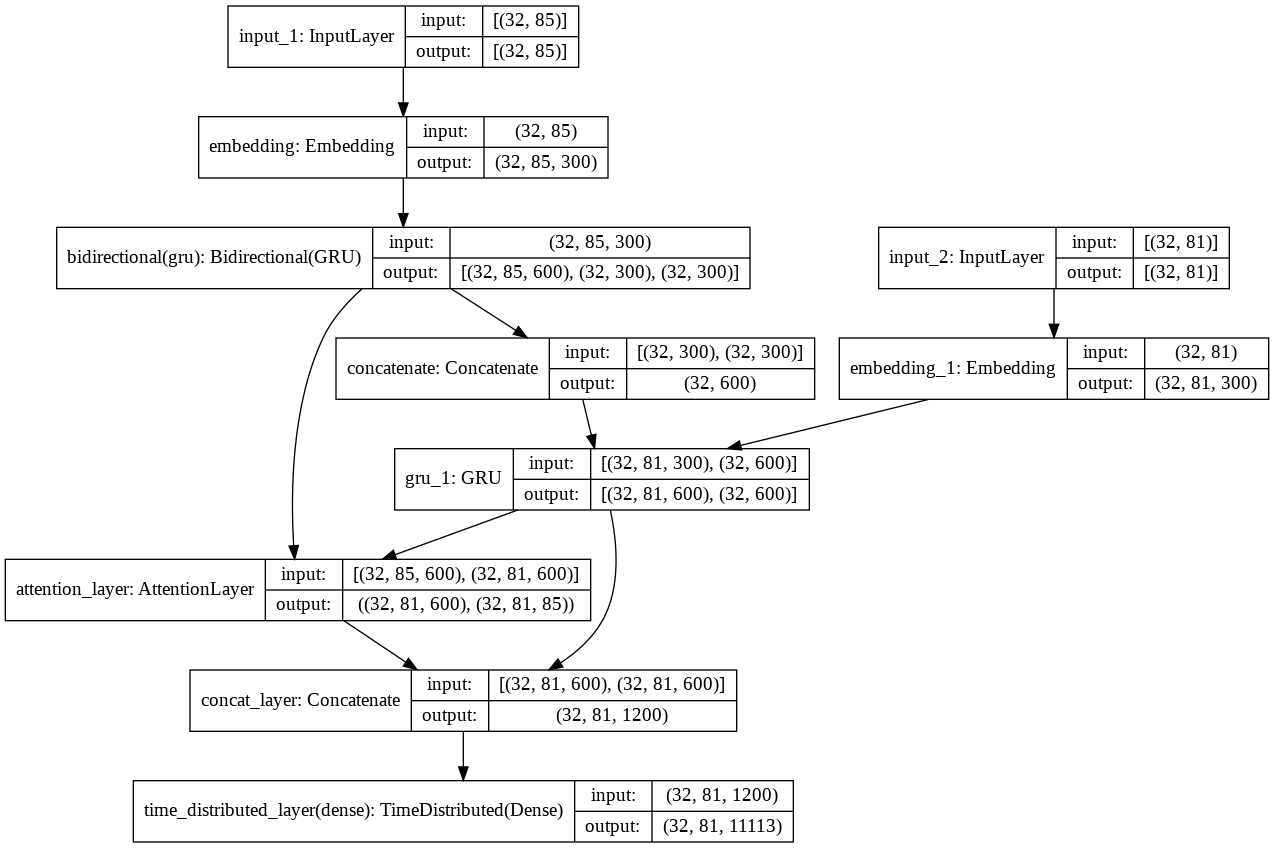

In [ ]:
#__main()__
enc_emb_layer, encoder_gru, dec_emb_layer, decoder_gru, attn_layer, decoder_dense, model = built_model(batch_size = 32, latent_dim = 300)
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

## Train the model

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def train_the_model(input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val,\
                    N_train_samples, N_val_samples, batch_size = 32, epochs = 40):
    history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = N_train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = N_val_samples//batch_size)
    return history

def plot_training_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(val_loss_values) + 1)

    plt.subplot(211)
    plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Test loss')
    plt.title('Training and val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid('off')
    plt.show()

    plt.subplot(212)
    plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Val accuracy')
    plt.title('Training and val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
125/125 [==============================] - 66s 524ms/step - loss: 2.1303 - acc: 0.7339 - val_loss: 1.7656 - val_acc: 0.7543
Epoch 2/40
125/125 [==============================] - 64s 512ms/step - loss: 1.6898 - acc: 0.7535 - val_loss: 1.6765 - val_acc: 0.7620
Epoch 3/40
125/125 [==============================] - 65s 522ms/step - loss: 1.5768 - acc: 0.7598 - val_loss: 1.6308 - val_acc: 0.7663
Epoch 4/40
125/125 [==============================] - 66s 531ms/step - loss: 1.4835 - acc: 0.7642 - val_loss: 1.6046 - val_acc: 0.7688
Epoch 5/40
125/125 [==============================] - 67s 535ms/step - loss: 1.3959 - acc: 0.7675 - val_loss: 1.5938 - val_acc: 0.7715
Epoch 6/40
125/125 [==============================] - 67s 540ms/step - loss: 1.3112 - acc: 0.7706 - val_loss: 1.5910 - val_acc: 0.7722
Epoch 7/40
125/125 [==============================] - 67s 539ms/step - loss: 1.2287 - acc: 0.7749 - val_loss: 1.60

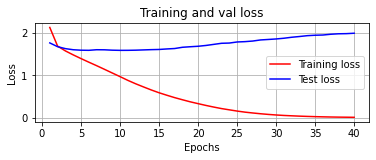

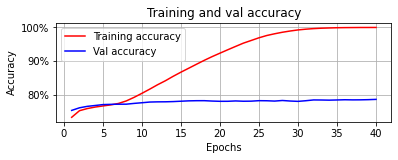

In [ ]:
#__main()__
history = train_the_model(input_tensor_train, target_tensor_train, input_tensor_val, target_tensor_val, N_train_samples, N_val_samples)
plot_training_history(history)

## Built the inference model

In [ ]:
# Solve the problem that colab cannot show Chinese plotting
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!mv SimHei.ttf /content

--2020-06-19 21:42:35--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  28.7MB/s    in 0.4s    

2020-06-19 21:42:36 (28.7 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      
mv: 'SimHei.ttf' and '/content/SimHei.ttf' are the same file


In [ ]:
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

# Solve the problem that colab cannot show Chinese plotting
import matplotlib.font_manager as fm
path = '//content/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=10)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# plot_attention_weights function from https://github.com/thushv89/attention_keras/blob/master/src/examples/utils/model_helper.py
def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())],fontproperties=fontprop)
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=24)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))
        
def built_inference_model(batch_size = 1, latent_dim = 300):
    # Encoder (Inference) model
    encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
    enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
    # Encode the input sequence to get the "Context vectors"
    encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])
    #encoder_model.summary()

    # Decoder (Inference) model
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
    encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
    decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
    # Get the embeddings of the decoder sequence
    dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
    # Final decoder model
    decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],\
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])
    #decoder_model.summary()

    return encoder_model, decoder_model

# decode token with k beam search
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = targ_lang.word_index['<start>']
    output, attent, states = decoder_model.predict([enc_outs, states_value, target_seq])
    sampled_token_index =  np.argsort(-output[0, -1, :])
    candidates = list()
    for idx in sampled_token_index[:k]:
        candidates.append([[idx], [[idx, attent]], [states], -np.log(output[0, -1, idx])])
    for l in range(max_length_targ):
        all_candidates = list()
        for i in range(len(candidates)):
            seq, atten, stas, score = candidates[i]
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = seq[-1]
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, stas[-1], target_seq])
            sampled_token_indices =  np.argsort(-output_tokens[0, -1, :])
            for index in sampled_token_indices[:k]:
                candidate = [seq + [index], atten + [[index, attention]], stas + [states_value], score - np.log(output_tokens[0, -1, index])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda item:item[-1])
        candidates = ordered[:k]
        if candidates[0][0][-1] == targ_lang.word_index['<end>']:
            break
    return candidates

# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

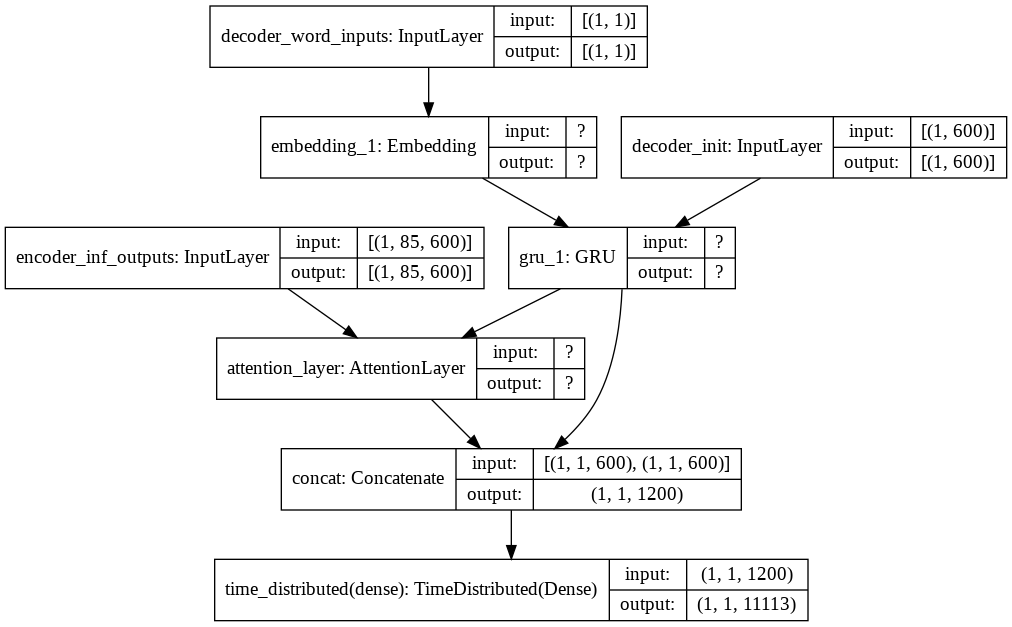

In [ ]:
#__main()__
encoder_model, decoder_model = built_inference_model(batch_size = 1, latent_dim = 300)
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

## Test deom

In [ ]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

Input Source sentence: 我 知道 你 最 喜欢 这 首 歌 ， 我 也 知道 你 的 心思 ， 我 想 你 。
Actual   Target  Translation: i know you like this song most and i know what you are thinking about , too , i miyou .
Predicted Target Translation: i know you like this song most and i know what you are thinking about , too , i miyou .


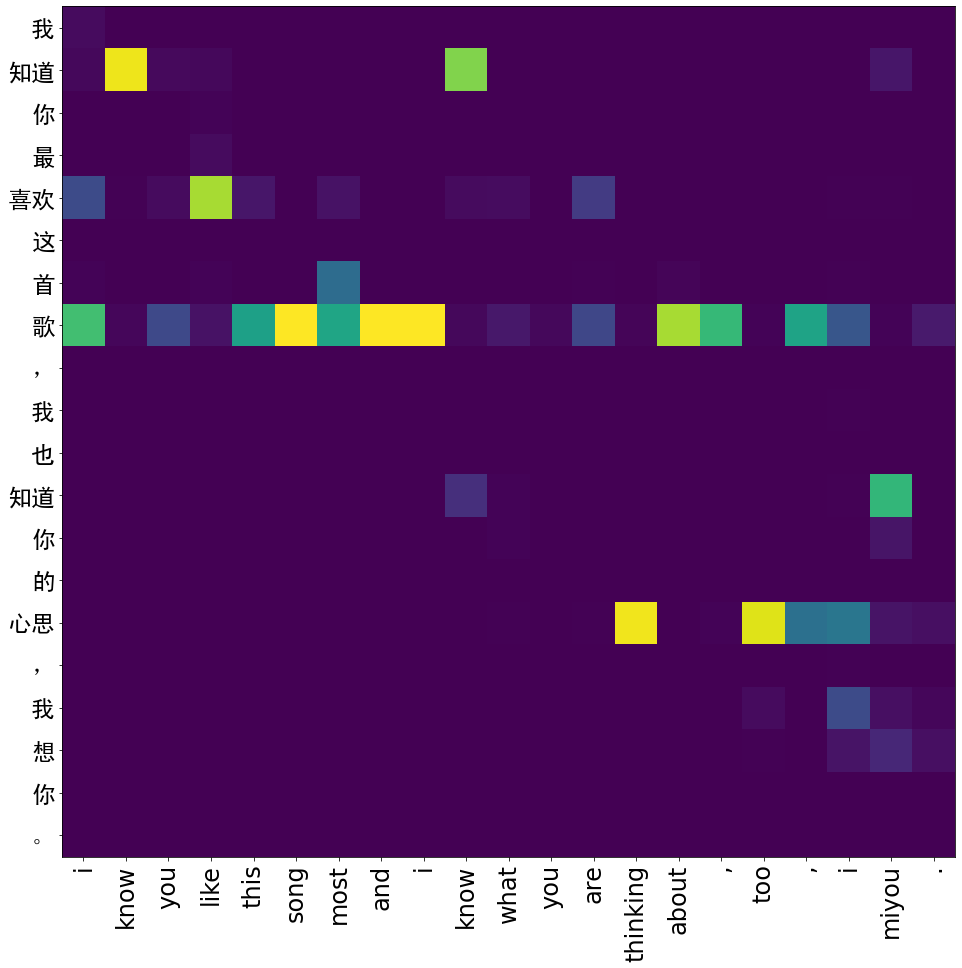

In [ ]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
candidates = decode_sequence_with_k_beam_search(input_seq, 3)
print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
print('Actual   Target  Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], inp_lang.index_word, targ_lang.index_word, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(targ_lang.index_word, candidates[0][0][:-1])[0:10]))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [[token for token in sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()]]
test = [token for token in sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()]
score = sentence_bleu(reference, test)
print('Test - Predicted Target Translation:', test)
print('Reference - Actual Target Translation:', reference)
print('Bleu score:',score)

Test - Predicted Target Translation: ['i', 'know', 'you', 'like', 'this', 'song', 'most', 'and', 'i', 'know', 'what', 'you', 'are', 'thinking', 'about', ',', 'too', ',', 'i', 'miyou', '.']
Reference - Actual Target Translation: [['i', 'know', 'you', 'like', 'this', 'song', 'most', 'and', 'i', 'know', 'what', 'you', 'are', 'thinking', 'about', ',', 'too', ',', 'i', 'miyou', '.']]
Bleu score: 1.0


In [ ]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = N_train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 4000

Input Source sentence: 为什么 图书馆 是 最 高 的 建筑 ？ 答案 因为 它 有所 有的 楼层 。
Actual Target Translation: why is the libray the highest building ? key it has the most stories .
Predicted Target Translation: why is the libray the highest building ? key it has the most stories .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 4000

Input Source sentence: 这 是 我 的 盘子 里 吃 晚 餐后 。 我 吃 了 很多 海鲜 。 偷笑 杭州 有 美味 的 海鲜 。 我 想 知道 在 中国 哪个 城市 有 最好 的 海鲜
Actual Target Translation: this is my plate after eating dinner . i ate a lot of seafood. hangzhou has delicious seafood. i wonder which city in china has the best seafood ?
Predicted Target Translation: this is my plate after eating dinner . i ate a lot of seafood. hangzhou has delicious seafood. i wonder which city in china has the best seafood ?
Bleu score: 1.0
----------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 22 in total number of 4000

Input Source sentence: 人们 为什么 轻言 放弃 ？ 因为 他们 只是 看到 前方 路途 遥远 ， 而 忘记了 身后 的 一路 坚持 。
Actual Target Translation: the reason why people give up so quickly is because they look at how far they still have to go , instead of how far they have come .
Predicted Target Translation: why do people give up easily ? because they focus on the long road ahead , and forget the long road they have come down .
Bleu score: 0.26387804640568047
-------------------------------------------------------------------------------------------------------------------------
Sample: 23 in total number of 4000

Input Source sentence: 终于 到 这里 了 ， 已经 非常 喜爱 这个 国家 了 。 等 不 及 要 开始 明天 的 演出 了
Actual Target Translation: finally here , love this country already. can t wait for the show tomorrow ! !
Predicted Target Translation: finally here , love this country already. can t wait for the show tomorrow ! !
Bleu score: 1.0
----------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 149 in total number of 4000

Input Source sentence: 不要 轻易 把 伤口 揭开 给 别人 看 ， 因为 别人 看的 是 热闹 ， 而 痛 的 却 是 自己 。
Actual Target Translation: not easily cut open to others , because others are hilarious , and the pain is yourself .
Predicted Target Translation: do not cut a minute to do not easily , to do something the worse , is kind to understand the pain .
Bleu score: 0.44588192733265836
-------------------------------------------------------------------------------------------------------------------------
Sample: 150 in total number of 4000

Input Source sentence: 不要 爱上 一 个 漂亮 的 人 ， 而 要 爱上 一 个 使 你 的 生活 变 漂亮 的 人 。
Actual Target Translation: don t love the one who is beautiful but love the one who can make your life beautiful
Predicted Target Translation: don t love the one who is beautiful but love the one who can make your life beautiful
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。

Input Source sentence: 有时 我们 去 公园 玩 的 时候 ， 最后 我们 会 踢 足球 。 公园 里 的 每个 人 都 很 和蔼可亲 也 很 友好 。 踢 足球 的 成员 有 大人 有 小孩 ， 有 中国人 也 有 外国人 ， 我 很 喜欢 这样 ， 大家 一起 玩 。 这个 小孩 只有 老大 身高 的 一半 ， 跑起来 速度 可是 老大 的 两 倍 快 呢
Actual Target Translation: sometimes when we go to the park we end up in football games. everyone is so nice at the park and they are very friendly . what i like is that the football games include adults and children and chinese and foreigners. this kid was half the size of the chief , but twice as fast ! !
Predicted Target Translation: sometimes when we go to the park we end up in football games. everyone is so nice at the park and they are very friendly . what i like is that the football games include adults and children and chinese and foreigners. this kid was half the size of the chief , but twice as fast ! !
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 3287 in tota

In [ ]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

Input Source sentence: 幸福 不 是 取决于 外界 环境 ， 它 由 我们 的 心态 来 决定 。
Actual Target Translation: happiness doesn t depend on any external conditions , it is governed by our mental attitude .
Predicted Target Translation: happiness is not the present of the weak but the truth is a man s not with its people who can t have .


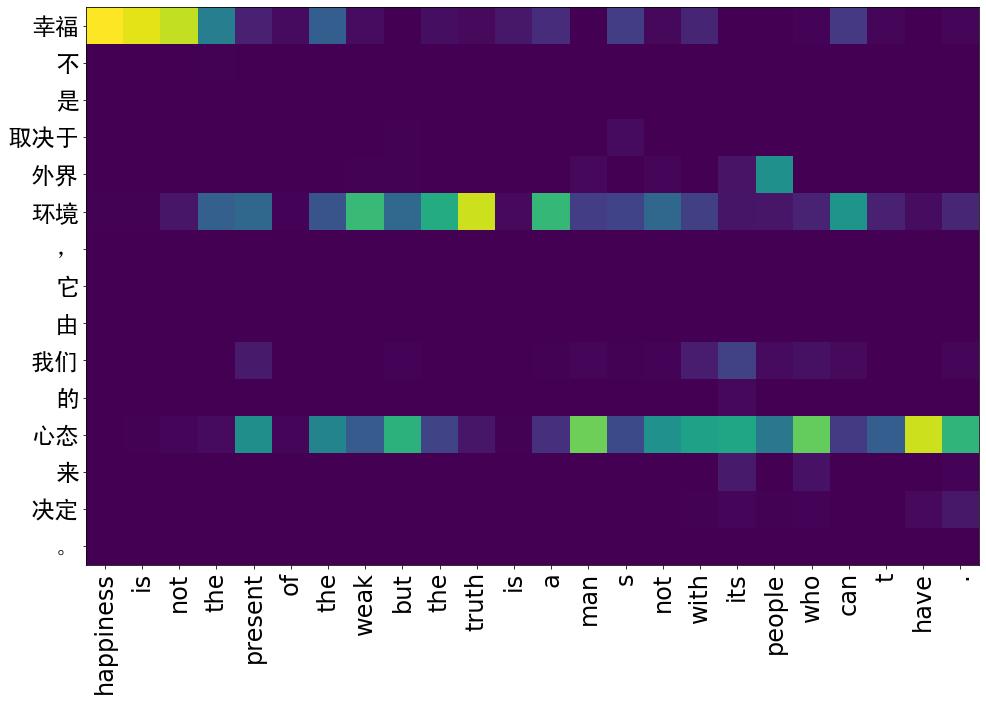

In [ ]:
(input_seq, actual_output), _ = next(test_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], inp_lang.index_word, targ_lang.index_word, \
                       base_dir=r"/content/drive/My Drive/NLP/NMT", \
                       filename='attention_{}.png'.format(sequence_to_text(targ_lang.index_word, candidates[0][0][:-1])[0:10]))

In [ ]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = N_val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 0 in total number of 1000

Input Source sentence: 当 你 跟 某人 约会 很 长 一 段 时间 并 发现 你们 的 关系 不 会 有 结果 之后 ， 你 是 不 是 曾 感觉 有 类似 下面 的 对话 ？ 如果 你 是 我 老公 ， 我 会 在 你 咖啡 里 下毒 如果 你 是 我 老婆 ， 我 宁愿 喝 下 它
Actual Target Translation: after you ve been dating someone for a long time and realize the relationship will not pan out for the long term do you ever feel like having the conversation like the one below ?
Predicted Target Translation: when you re the only you know , you are at me , then you can make me even , but i m scared at you . <end> , i can t walk away. i m just i know i m gonna .
Bleu score: 0.5139409225754329
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 1000

Input Source sentence: 折叠 插页 屈折 的 内文 书页 。 张开时 它 较 书页 的 尺寸 为 大
Actual Target Translation: fold out folded sheet in text which opens out beyond the page size. also called gatefold , throw
Predicted Target Translation: mirrors in th

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 2 in total number of 1000

Input Source sentence: 如果 那 就 是 你 想要 的 ， 只要 你 清楚 记住 这 一 点 ， 就 不 会 在乎 中间 的 好 与 坏 ， 就 不 会 有 好坏 之 分 。 享受 过程 ， 拥抱 结果
Actual Target Translation: morning xmas. if that s what you want , and you know it , then there is nothing good or bad within . enjoy the process and welcome the result .
Predicted Target Translation: if you re the worst things that you don t care for the , you don t know what you re the number of the world , then you get to make your life .
Bleu score: 0.3768478744790068
-------------------------------------------------------------------------------------------------------------------------
Sample: 3 in total number of 1000

Input Source sentence: 指定 的 路径 无效 比如 在 未 映射 的 驱动器 上
Actual Target Translation: the specified path is invalid , such as being on an unmapped drive .
Predicted Target Translation: the price of the value of a state is out of nature to structures .
Bleu score: 0.668740304976422
---------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。

Input Source sentence: 成功 意味 着 屡败 屡战 而 不 丧失 热情 。
Actual Target Translation: success consists of going from failure to failure without loss of enthusiasm .
Predicted Target Translation: a good man can do with a mistake , but is not a strong .
Bleu score: 0.5081327481546147
-------------------------------------------------------------------------------------------------------------------------
Sample: 287 in total number of 1000

Input Source sentence: 中国 的 粉丝们 ， 祝 你们 七 夕 情人节 快乐 ！ 我 希望 所有 的 女生 在 这 特别 的 节日 里 都 能 心想 事成
Actual Target Translation: i wish a wonderful valentine s day to all my china fans ! i hope all my girls get what they want on this special day !
Predicted Target Translation: happy singles day i m happy ! good day in the year i m really ! you all my fans are celebrating !
Bleu score: 0.30689762180747027
-------------------------------------------------------------------------------------------------------------------------
Sample: 288 in total nu

## Train on full set

Number of samples for Training/Testing: 5000, 66
encoder_inputs/enc_emb shape: (32, 85), (32, 85, 300)
decoder_inputs/dec_emb shape: (32, 81), (32, 81, 300)
decoder_outputs/attn_out shape: (32, 81, 600), (32, 81, 600)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 85)]           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (32, 85, 300)        4126800     input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(32, 81)]           0                                            
________________________________________________________________________

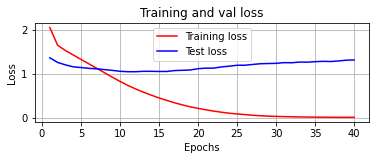

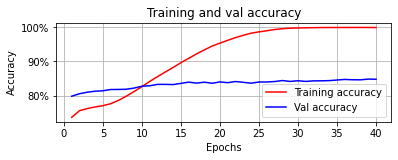

In [ ]:
input_file_path = [r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Bi-Microblog_zh.tok',\
                   r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Bi-Microblog_en.tok']
test_file_path = [r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Testing-Data_zh.tok', \
                   r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Testing-Data_en.tok']

# Load full Microblog data and Twitter test data
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_file_path[0], input_file_path[1])
input_tensor_ts, target_tensor_ts = create_dataset(test_file_path[0], test_file_path[1])
input_tensor_ts, target_tensor_ts = shuffle(inp_lang.texts_to_sequences(input_tensor_ts[4934:]), targ_lang.texts_to_sequences(target_tensor_ts[4934:]))
# Number of Training/Testing samples
N_tr_samples, N_ts_samples = len(input_tensor), len(input_tensor_ts)
print('Number of samples for Training/Testing: {}, {}'.format(N_tr_samples, N_ts_samples))

enc_emb_layer, encoder_gru, dec_emb_layer, decoder_gru, attn_layer, decoder_dense, model = built_model(batch_size = 32, latent_dim = 300)
history_final = train_the_model(input_tensor, target_tensor, input_tensor_ts, target_tensor_ts, N_tr_samples, N_ts_samples)
plot_training_history(history_final)
encoder_model, decoder_model = built_inference_model(batch_size = 1, latent_dim = 300)

## Test on test set

In [ ]:
# Make predictions on the Test dataset
ts_gen = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = 1)

Input Source sentence: 勇气 就 是 虽 感 恐惧 ， 但 仍 会 前行 。
Actual Target Translation: courage is being afraid but going on <UNK> .
Predicted Target Translation: courage is resistance of fear , but of fear is not afraid .


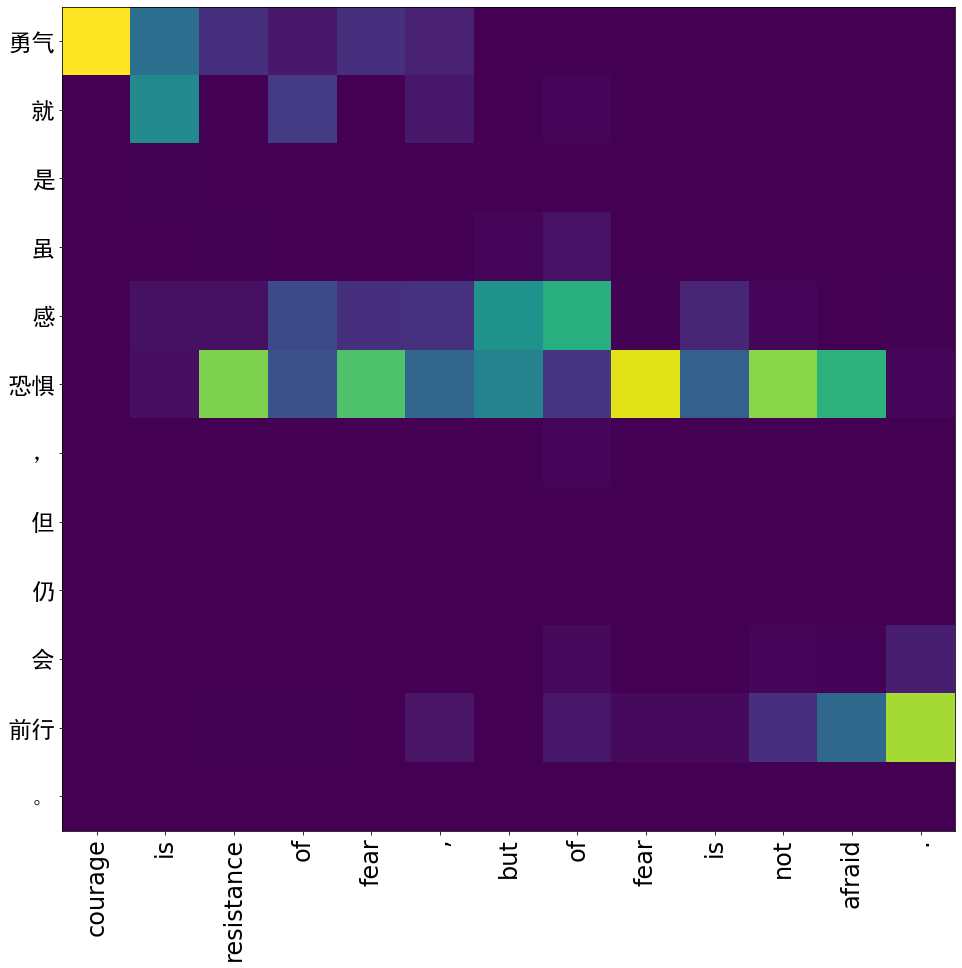

In [ ]:
(input_seq, actual_output), _ = next(ts_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], inp_lang.index_word, targ_lang.index_word, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(targ_lang.index_word, candidates[0][0][:-1])[0:10]))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
ts_gen = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = 1)
N_samples = N_ts_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(ts_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(inp_lang.index_word, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(targ_lang.index_word, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(targ_lang.index_word, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 0 in total number of 66

Input Source sentence: 新年 是 给 我们 一 个 新 的 机会 去 原谅 ， 去 进步 ， 去 给予 更多 ， 去 爱得 更 多 。
Actual Target Translation: new year is about getting another chance . a chance to forgive , to do better , to give more , to love more .
Predicted Target Translation: i wish a wonderful mind comes on a wall day , and we can t love more than to love more than to let go .
Bleu score: 0.17895706401541522
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 1 in total number of 66

Input Source sentence: 不 是 不 追求 只是 不 去 强求 。 淡然 地 过 着 自己 的 生活 ， 不要 <UNK> ， 只 求 <UNK> 。
Actual Target Translation: pursue not just don t go not <UNK> <UNK> of my life. not grandeur but <UNK> assured .
Predicted Target Translation: don t be afraid by life , with your life , and not in life but we had a little life .
Bleu score: 0.32253883071974426
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 2 in total number of 66

Input Source sentence: 坦然 面对 和 接受 事实 。
Actual Target Translation: you will just flow and accept things as they are .
Predicted Target Translation: a good mood to be with by facing yourself , it will be live .
Bleu score: 0.6042750794713536
-------------------------------------------------------------------------------------------------------------------------
Sample: 3 in total number of 66

Input Source sentence: 勇气 就 是 虽 感 恐惧 ， 但 仍 会 前行 。
Actual Target Translation: courage is being afraid but going on <UNK> .
Predicted Target Translation: courage is resistance of fear , but of fear is not afraid .
Bleu score: 0.42311785416105785
-------------------------------------------------------------------------------------------------------------------------
Sample: 4 in total number of 66

Input Source sentence: 真实 生活 ， 无需 <UNK> 真心 去 爱 ， 不 要 依赖 认真 倾听 ， 莫 要 <UNK> <UNK> 说话 ， <UNK> 攻击 。
Actual Target Translation: live without pretending love without depending lis